In [7]:
import pandas as pd

# Data Loading

In [8]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())

     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2  

# Data Split

In [9]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    x, y = data_handler.split_data(data=df_train[i], target_col='target', drop_cols=['target', 'id'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    x, y = data_handler.split_data(df_test[i], target_col='target', drop_cols=['target', 'id'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [10]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(f"Monk {i+1} [TRAIN]: " + str(x_train[i].shape))
    print(f"Monk {i+1} [TEST]: " + str(x_test[i].shape))

Monk 1 [TRAIN]: (124, 17)
Monk 1 [TEST]: (432, 17)
Monk 2 [TRAIN]: (169, 17)
Monk 2 [TEST]: (432, 17)
Monk 3 [TRAIN]: (122, 17)
Monk 3 [TEST]: (432, 17)


# Grid Search parameters

In [11]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
       0: {
        'hidden_units': [3, 4],
        'patience': [15, 30],
        'learning_rate': [0.3, 0.4],
        'batch_size': [2, 4, 6],
        'nesterov': ["T", "F"],
        'epochs': [340, 440, 450],
        'momentum': [0.6, 0.7, 0.8]
    },
    1: {
        'hidden_units': [3, 4, 5],
        'patience': [10,100,200],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [float(i/100) for i in range(1,101,5)] + [0.999, 0.9999],
        'batch_size': [10, 15, 30, 60], # 169 ROWS
        'epochs': [int(250+epochs) for epochs in range(0,200,20)],
        'momentum': [float(i/100) for i in range(50,90,5)],
        'nesterov': ["T", "F"],
    },
    2: {
        'hidden_units': [2, 3],
        'patience': [10,15,30],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [float(i/100) for i in range(1,10)],
        'batch_size': [7, 8, 9, 32, 64],
        'epochs': [int(350+epochs) for epochs in range(0,50,10)],
        'weight_decay': [float(i/1000) for i in range(1,10)],
        'momentum': [float(i/1000) for i in range(10,90,5)] + [float(i/100) for i in range(10,90,5)],
        'nesterov': ["T", "F"]
    }
}

# Model Selection

## Best Hyperparameters Research

In [12]:
from sklearn.model_selection import StratifiedKFold
from api.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: list[BinaryNN] = []

# Different values per dataset
trials_list = [40, 30, 50]
k_values = [5, 5, 5]
n_hidden_layers_list = [1, 1, 1]

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values
    y = y_train[dataset_i].values
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
    for i in range(trials_list[dataset_i]):
        #if i != 2:
        #    continue

        # Random parameters
        params = data_handler.random_dictionary(param_space[dataset_i])

        # Creation of the Neural Network object
        nn_i = BinaryNN(params=params, monk_i=dataset_i+1, trial=i+1)

        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            # Building the model
            nn_i.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])

            # Training the model
            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

            # Evaluating the model
            nn_i.evaluate(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)

        # Print the results of this trial
        print("------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("-------------------- Best Hyperparameters -------------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Update best hyperparameters if: no high overfitting AND (higher mean VL accuracy OR (equal mean AND
        if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
            and (
                    nn[dataset_i].mean_vl_accuracy < nn_i.mean_vl_accuracy \
                or (
                    nn[dataset_i].mean_vl_accuracy == nn_i.mean_vl_accuracy and nn[dataset_i].mean_tr_accuracy < nn_i.mean_tr_accuracy
                    )
            ):
            nn[dataset_i] = nn_i

        # Case of TR/VL AND TR/VL loss minor
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy >= 0.98 \
            and nn_i.mean_tr_accuracy == nn[dataset_i].mean_tr_accuracy \
            and nn_i.mean_vl_accuracy == nn[dataset_i].mean_vl_accuracy \
            and abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02 \
            and nn_i.mean_vl_loss < nn[dataset_i].mean_vl_loss \
            and nn_i.mean_tr_loss < nn[dataset_i].mean_tr_loss:
            nn[dataset_i] = nn_i

        # Exit case
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
            and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
            and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
            nn[dataset_i] = nn_i
            break

    # Print output
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    print("\n\n")





------------------ Current Hyperparameters ------------------
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'hidden_units': 3, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'F', 'epochs': 450, 'momentum': 0.8}
 Mean Training Loss:       0.042614351212978366
 Mean Validation Loss:     0.08504613339900971
 Mean Training Accuracy:   0.953636372089386
 Mean Validation Accuracy: 0.8949999928474426
-------------------- Best Hyperparameters -------------------
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'hidden_units': 3, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'F', 'epochs': 450, 'momentum': 0.8}
 Mean Training Loss:       0.042614351212978366
 Mean Validation Loss:     0.08504613339900971
 Mean Training Accuracy:   0.953636372089386
 Mean Validation Accuracy: 0.8949999928474426



------------------ Current Hyperparameters ------------------
 Monk:           

KeyboardInterrupt: 

## Print of best Hyperparameters and Plots


### Best Hyperparameters for Monk 1 ###
 Monk:                     1
 Trial:                    8
 Hyperparameters:          {'hidden_units': 4, 'patience': 30, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'T', 'epochs': 440, 'momentum': 0.7}
 Mean Training Loss:       0.00010913382429862395
 Mean Validation Loss:     0.0007729498873231932
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 2 ###
 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.56, 'batch_size': 30, 'epochs': 350, 'momentum': 0.75, 'nesterov': 'F'}
 Mean Training Loss:       0.00067455610842444
 Mean Validation Loss:     0.001681895600631833
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 3 ###
 Monk:                     3
 Trial:                    29
 Hyperparameters:          {'hidden_

"\nBest Hyperparameters for Monk 2\n Monk:                     2\n Trial:                    3\n Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 500, 'learning_rate': 0.999, 'batch_size': 60, 'epochs': 290, 'momentum': 0.75, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}\n Mean Training Loss:       0.0006283932307269424\n Mean Validation Loss:     0.004200904699973762\n Mean Training Accuracy:   1.0\n Mean Validation Accuracy: 1.0\n\n### Best Hyperparameters for Monk 3 ###\n Monk:                     3\n Trial:                    14\n Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 30, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.07, 'batch_size': 7, 'epochs': 370, 'weight_decay': 0.002, 'momentum': 0.08, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}\n Mean Training Loss:       0

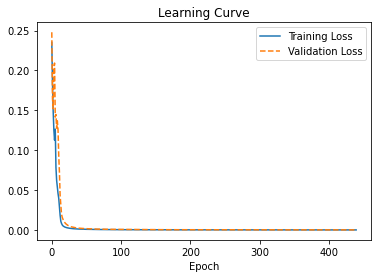

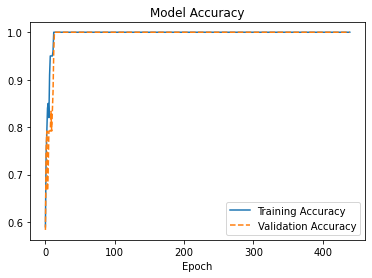

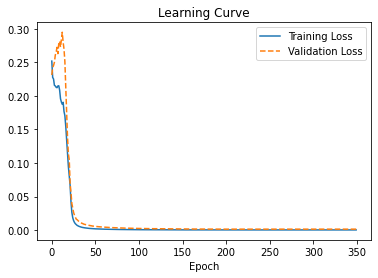

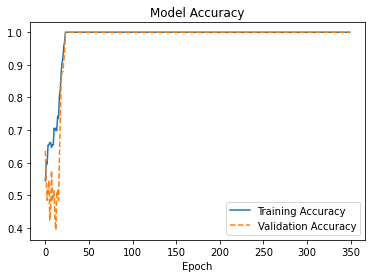

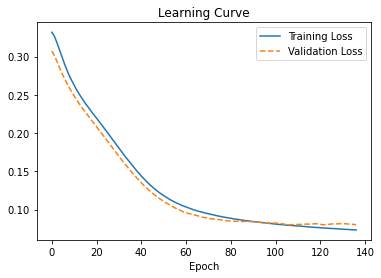

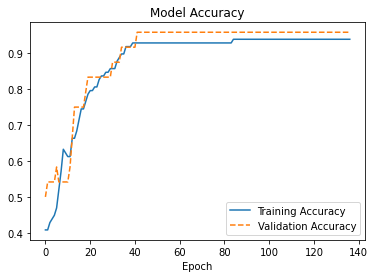

In [13]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()

    # Plot the learning curve
    nn[dataset_i].print_plot()   

   
 
    # BEST L CURVE M1: >(semismoothed)
    # Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1500, 'learning_rate': 0.999, 'batch_size': 17, 'epochs': 350, 'weight_init': 'glorot_normal', 'momentum': 0.4, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    #  Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.5, 'batch_size': 32, 'epochs': 370, 'weight_init': 'lecun_normal', 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    # Hyp:  {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.99, 'batch_size': 16, 'epochs': 530, 'weight_init': 'lecun_normal', 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    
    # BEST SMOOTHED CURVE MONK1:   HyperparameterS: {'hidden_units': 4, 'patience': 30, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 440, 'momentum': 0.6}
                                                     #Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'F', 'epochs': 440, 'momentum': 0.7, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

   # BEST SMOOTHER PT2 MONK2:  {'hidden_units': 4, 'patience': 10, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'T', 'epochs': 450, 'momentum': 0.3, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

    

'''
Best Hyperparameters for Monk 2
 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 500, 'learning_rate': 0.999, 'batch_size': 60, 'epochs': 290, 'momentum': 0.75, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.0006283932307269424
 Mean Validation Loss:     0.004200904699973762
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 3 ###
 Monk:                     3
 Trial:                    14
 Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 30, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.07, 'batch_size': 7, 'epochs': 370, 'weight_decay': 0.002, 'momentum': 0.08, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.059438984096050265
 Mean Validation Loss:     0.07536792308092118
 Mean Training Accuracy:   0.9508310675621032
 Mean Validation Accuracy: 0.934333324432373

 '''

## Retraining Phase

In [14]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Training the model
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    


### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    8
 Hyperparameters:          {'hidden_units': 4, 'patience': 30, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'T', 'epochs': 440, 'momentum': 0.7}
 Mean Training Loss:       0.00010913382429862395
 Mean Validation Loss:     0.0007729498873231932
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Retraining of Monk 2 ###
 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.56, 'batch_size': 30, 'epochs': 350, 'momentum': 0.75, 'nesterov': 'F'}
 Mean Training Loss:       0.00067455610842444
 Mean Validation Loss:     0.001681895600631833
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Retraining of Monk 3 ###
 Monk:                     3
 Trial:                    29
 Hyperparameters:          {'hidden_units': 3, 'patience': 30, 'facto

# Testing Phase

In [26]:

# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    x = x_train[dataset_i].values
    y_fit = y_train[dataset_i].values
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values
    

    # Evaluate the Model on TS set
    nn[dataset_i].fit(
        x_train=x,
        y_train=y_fit,
        x_val = X,
        y_val = y_test
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    # Prints the results obtained
    print(nn[dataset_i])
    # Plot the learning curve
    nn[dataset_i].print_plot()   





AttributeError: 'numpy.ndarray' object has no attribute 'values'